In [1]:
!git clone https://github.com/jeffheaton/t81_558_deep_learning.git

Cloning into 't81_558_deep_learning'...
remote: Enumerating objects: 4745, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 4745 (delta 29), reused 48 (delta 18), pack-reused 4685
Receiving objects: 100% (4745/4745), 242.65 MiB | 36.80 MiB/s, done.
Resolving deltas: 100% (3182/3182), done.


In [2]:
# HIDE OUTPUT
CMD = "wget https://raw.githubusercontent.com/Diyago/"\
  "GAN-for-tabular-data/master/requirements.txt"

!{CMD}
!pip install -r requirements.txt
!pip install tabgan

--2022-06-11 12:28:20--  https://raw.githubusercontent.com/Diyago/GAN-for-tabular-data/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     197  --.-KB/s    in 0s      

2022-06-11 12:28:20 (9.73 MB/s) - ‘requirements.txt’ saved [197/197]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.2 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 748.8 MB 19 kB/s 
     |████████████████████████████████| 9.9 MB 28.1 MB/s 
     |████████████████████████████████| 1.2 MB 50.7 MB/s 
     |████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 1.8 MB/s 


In [1]:
# HIDE OUTPUT
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score


# Loading csv tabular data(Must process to get only the numerical features and Label for classification or regression)

In [2]:
df_label_all = pd.read_csv("/content/one_zerolittle.csv")
df_label_all.head()

,s13,s48,s52,n1,n2,n3,n4,n5,n6,n7,...,x,~1,a,b,c,d,op: A,op: B,op: C,op: D
0,1,1,1,7.319978,1.071222,3,6.029996,-32.574983,0.007418,-9.283087,...,0,1,0,1,0,0,0,0,0,1
1,0,1,1,6.667097,0.699584,6,2.352073,-32.394892,0.014828,-9.174026,...,0,1,0,0,1,0,0,0,1,0
2,1,1,1,16.571195,2.504946,8,6.776169,-32.576455,0.011080,-8.851669,...,1,0,0,1,0,0,0,1,0,0
3,1,1,1,12.769811,1.908708,6,5.917154,-32.508091,0.018298,-8.879981,...,0,1,0,0,1,0,0,0,0,1
4,1,0,1,16.065690,2.463559,3,6.765048,-32.345645,0.023098,-9.042806,...,0,1,0,1,0,0,0,0,1,0


# Splitting Dataset

In [5]:
# Split into training and test sets
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_label_all.drop("label", axis=1),     #here y label is denoted as 'label'
    df_label_all["label"],
    test_size=0.20,
    random_state=42,
)

# Create dataframe versions for tabular GAN
df_x_test, df_y_test = df_x_test.reset_index(drop=True), \
  df_y_test.reset_index(drop=True)
df_y_train = pd.DataFrame(df_y_train)
df_y_test = pd.DataFrame(df_y_test)

# Pandas to Numpy
x_train = df_x_train.values
x_test = df_x_test.values
y_train = df_y_train.values
y_test = df_y_test.values

# Fitting Xgboost model to training data

In [7]:

model = XGBClassifier()
model.fit(x_train, y_train)

# Validating the model
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
print(f'Balance accuracy is {balanced_accuracy_score(y_test, predictions)}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Balance accuracy is 0.7364431942491014


# Training the GAN and generate new data

In [9]:
from tabgan.sampler import GANGenerator
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import re
df_x_train = df_x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))    # to tackle an error
df_x_test = df_x_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


how_many_times_data_needed = 2.2   #how many data generation needed
gen_x, gen_y = GANGenerator(gen_x_times=how_many_times_data_needed, cat_cols=None,   #turn on the gpu to process quickly
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=True,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 120, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 800,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 500,}).generate_data_pipe(df_x_train, df_y_train,\
          df_x_test, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)

Fitting CTGAN transformers for each column:   0%|          | 0/51 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
print(f'previously original data was of size {df_label_all.shape}')
print(f'Newly generated data is of size {gen_x.shape}')

previously original data was of size (6359, 51)
Newly generated data is of size (9462, 50)


# Checking Generated Data Label

In [11]:
gen_y

0       1
1       0
2       0
3       0
4       0
       ..
9457    0
9458    1
9459    0
9460    1
9461    1
Name: label, Length: 9462, dtype: int64

# See generated data distribution

Text(0, 0.5, 'Frequency')

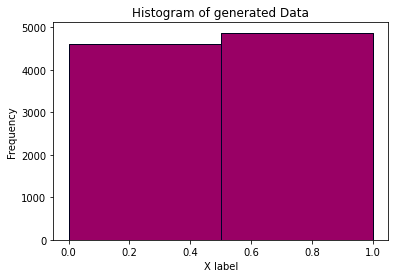

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(gen_y, color = 'red', edgecolor = 'black',
         bins = 2)

# seaborn histogram
sns.distplot(gen_y, hist=True, kde=False, 
             bins=2, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of generated Data')
plt.xlabel('X label')
plt.ylabel('Frequency')

# Check the generated data quality (Less the difference between the previously score in original data better the quality)

In [14]:
pred = model.predict(gen_x.values)
pred = [np.round(value) for value in pred]


from sklearn.metrics import balanced_accuracy_score
score = balanced_accuracy_score(gen_y, pred)
print("Final score (Balanced acc): {}".format(score))

Final score (Balanced acc): 0.5629858933717212


In [ ]:
gen_x['label'] = gen_y

# Saving Synthetic Data

In [ ]:
gen_x.to_csv('New one_zero even_more.csv', index = False)